Mounting Google Drive

In [1]:

!pip install torchsummary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
%load_ext autoreload

Importing libraries

In [3]:
import torch
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

import numpy as np

from utils import (
   test, train, plot_losses, plot_incorrect_prediction

)

from model import Net
from torchsummary import summary

from torch.optim.lr_scheduler import StepLR
%matplotlib inline

Defining data tranformations

In [4]:
train_transforms = transforms.Compose([
    transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomRotation((-10., 10.), fill=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])


Downloading MNIST dataset and splitting to train and test set

In [5]:
train_data = datasets.CIFAR10('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.CIFAR10('../data', train=False, download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
SEED = 1
BATCHSIZE = 128
BATCHSIZE_2 = 64
NUM_OF_WORKER = 4
EPOCHS = 15

In [7]:
# Checking for CUDA
cuda = torch.cuda.is_available()
print("CUDA Available",cuda)

torch.manual_seed(SEED)
if cuda:
  torch.cuda.manual_seed(SEED)

kwargs = {'shuffle' : True,'batch_size' : BATCHSIZE,'num_workers': 4, 'pin_memory': True} if cuda else {'shuffle' : True,'batch_size' : BATCHSIZE_2}

train_loader = torch.utils.data.DataLoader(train_data, **kwargs) # creating train data loader
test_loader = torch.utils.data.DataLoader(test_data, **kwargs) # creating test dataloader

CUDA Available True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [8]:
classes = ['plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Creating Data Loaders from train data and test data

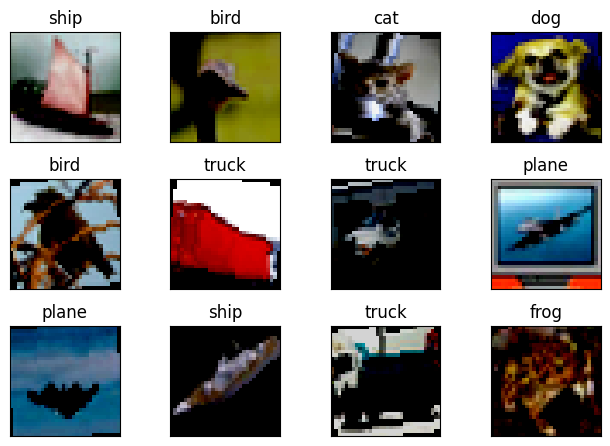

In [9]:
batch_data, batch_label = next(iter(train_loader))
fig = plt.figure()
for i in range(12):
    plt.subplot(3,4,i+1)
    plt.tight_layout()
    plt.imshow(np.transpose(batch_data[i], (1, 2, 0)), cmap='gray')
    plt.title(classes[batch_label[i].item()])
    plt.xticks([])
    plt.yticks([])
plt.show()

Transferring model to GPU and printing model summary

In [11]:
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")
model = Net(norm="BN").to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 32, 32]             270
       BatchNorm2d-2           [-1, 10, 32, 32]              20
         Dropout2d-3           [-1, 10, 32, 32]               0
            Conv2d-4           [-1, 10, 32, 32]             900
       BatchNorm2d-5           [-1, 10, 32, 32]              20
         Dropout2d-6           [-1, 10, 32, 32]               0
            Conv2d-7           [-1, 16, 32, 32]             160
         MaxPool2d-8           [-1, 16, 16, 16]               0
            Conv2d-9           [-1, 24, 16, 16]           3,456
      BatchNorm2d-10           [-1, 24, 16, 16]              48
        Dropout2d-11           [-1, 24, 16, 16]               0
           Conv2d-12           [-1, 16, 16, 16]           3,456
      BatchNorm2d-13           [-1, 16, 16, 16]              32
        Dropout2d-14           [-1, 16,

In [ ]:
model =  Net(norm='BN').to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer)
    test(model, device, test_loader)

EPOCH: 0


Train: Loss=1.2561 Batch_id=390 Accuracy=41.28: 100%|██████████| 391/391 [00:45<00:00,  8.63it/s]


Test set: Average loss: 1.3283, Accuracy: 5073/10000 (50.73%)

EPOCH: 1


Train: Loss=1.2849 Batch_id=390 Accuracy=54.57: 100%|██████████| 391/391 [00:48<00:00,  8.09it/s]


Test set: Average loss: 1.1224, Accuracy: 5976/10000 (59.76%)

EPOCH: 2


Train: Loss=1.0658 Batch_id=390 Accuracy=59.82: 100%|██████████| 391/391 [00:44<00:00,  8.81it/s]


Test set: Average loss: 0.9711, Accuracy: 6518/10000 (65.18%)

EPOCH: 3


Train: Loss=1.0777 Batch_id=390 Accuracy=63.25: 100%|██████████| 391/391 [00:43<00:00,  8.91it/s]


Test set: Average loss: 0.9428, Accuracy: 6633/10000 (66.33%)

EPOCH: 4


Train: Loss=0.9964 Batch_id=150 Accuracy=65.07:  38%|███▊      | 150/391 [00:17<00:28,  8.60it/s]

In [ ]:
plot_losses()

In [12]:
torch.save(model.state_dict(), 'model_bn.pth')

In [13]:
model1 = Net(norm="BN").to(device)
model1.load_state_dict(torch.load('model_bn.pth'))

<All keys matched successfully>

## Plot Losses

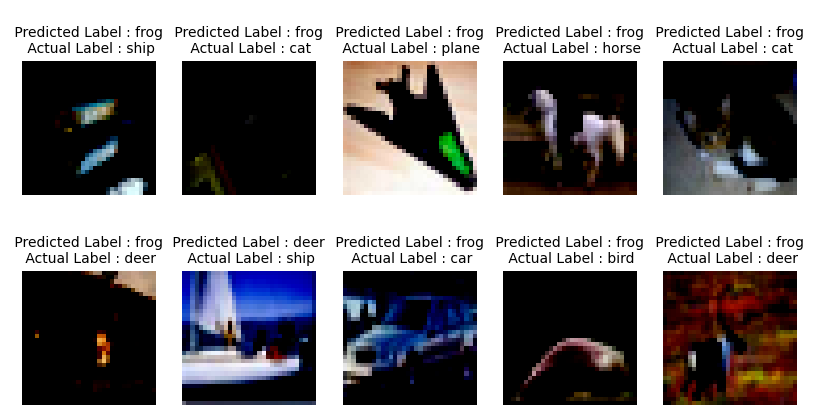

In [14]:
wrong_prediction_list = []
model1.eval()
for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    output = model1(images)
    pred = output.argmax(dim=1, keepdim=True)  # get the index of the maximum probabilities
    match = pred.eq(labels.view_as(pred)).to('cpu').numpy()
    for j, i in enumerate(match):
        if(i == False):
            wrong_prediction_list.append((images[j], pred[j].item(), labels[j].item()))
plot_incorrect_prediction(wrong_prediction_list, n=10 )

In [18]:
from utils import get_all_predictions, get_incorrrect_predictions, prepare_confusion_matrix
from visualize import plot_confusion_matrix

all_preds, all_targets = get_all_predictions(model1, test_loader, device)
confusion_matrix = prepare_confusion_matrix(all_preds, all_targets, class_map)
plot_confusion_matrix(confusion_matrix, class_map, False)

ImportError: ignored